In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# OUR STUFF
# ROOT DIR FOR IMAGES: /Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/images_original/

# Loading the Data

In [3]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_meta = pd.read_csv('/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/images_original/metadata.csv')
df_meta.head()
print(df_meta.columns)

Index(['Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size',
       'File Location', 'Download Timestamp'],
      dtype='object')


In [5]:
#full mammogram images
full_mammo = df_meta[df_meta['Series Description']=='full mammogram images']['File Location']

In [6]:
# set correct image path for image types
imdir = '/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/images_original/CBIS_DDSM/'

In [7]:
# change directory path of images
full_mammo = full_mammo.replace(r'\.\\CBIS-DDSM\\', imdir, regex=True)
full_mammo = full_mammo.replace(r'\\', r"/", regex=True)

# view new paths
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])

Full mammo Images paths:

/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/images_original/CBIS_DDSM/Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.384159464510350889125645400702639717613/1.3.6.1.4.1.9590.100.1.2.174390361112646747718661211471328897934


In [8]:
# organize image paths
full_mammo_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('code',
 '/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/images_original/CBIS_DDSM/Mass-Training_P_02092_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.322851018411213611731661082961359065216/1.3.6.1.4.1.9590.100.1.2.290251769212905477734669932883242291615')

# Mass Dataset

In [9]:
# load the mass dataset
mass_train = pd.read_csv('/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/mass-training.csv')
mass_test = pd.read_csv('/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/data/CBIS-DDSM/mass-test.csv')

mass_train.head()

,img,img_path,label
0,Mass-Training_P_00001_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
1,Mass-Training_P_00001_LEFT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
2,Mass-Training_P_00004_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN
3,Mass-Training_P_00004_LEFT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN
4,Mass-Training_P_00004_RIGHT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN


In [10]:
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        print(img)
        img_name = img[1].split("/")[2]
        data.iloc[index,1] = full_mammo_dict[img_name]
        
# apply to datasets
#fix_image_path(mass_train)
#fix_image_path(mass_test)

In [11]:
# check unique values in pathology column
mass_train["label"].unique()

array(['MALIGNANT', 'BENIGN'], dtype=object)

In [12]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img       1225 non-null   object
 1   img_path  1225 non-null   object
 2   label     1225 non-null   object
dtypes: object(3)
memory usage: 28.8+ KB


In [13]:
# rename columns
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

,img,img_path,label
0,Mass-Training_P_00001_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
1,Mass-Training_P_00001_LEFT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
2,Mass-Training_P_00004_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN
3,Mass-Training_P_00004_LEFT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN
4,Mass-Training_P_00004_RIGHT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN


In [14]:
# check for null values
mass_train.isnull().sum()

img         0
img_path    0
label       0
dtype: int64

In [15]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

KeyError: 'mass_shape'

In [ ]:
# quantitative summary of features
mass_train.describe()

,img,img_path,label
count,1225,1225,1225
unique,1225,1225,2
top,Mass-Training_P_00001_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN
freq,1,1,629


In [ ]:
# view mass_test
mass_test.head()

,img,img_path,label
0,Mass-Test_P_00016_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
1,Mass-Test_P_00016_LEFT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
2,Mass-Test_P_00017_LEFT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
3,Mass-Test_P_00017_LEFT_MLO,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,MALIGNANT
4,Mass-Test_P_00032_RIGHT_CC,/Code/KEX-Job/Breast-Cancer-Detection-Mammogra...,BENIGN


In [ ]:
# check datasets shape
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1225, 3)
Shape of mass_test: (359, 3)


In [ ]:
mass_test.isnull().sum()

img         0
img_path    0
label       0
dtype: int64

In [ ]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [ ]:
# fill in missing values using the backwards fill method
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

KeyError: 'mass_margins'

# Visualizations

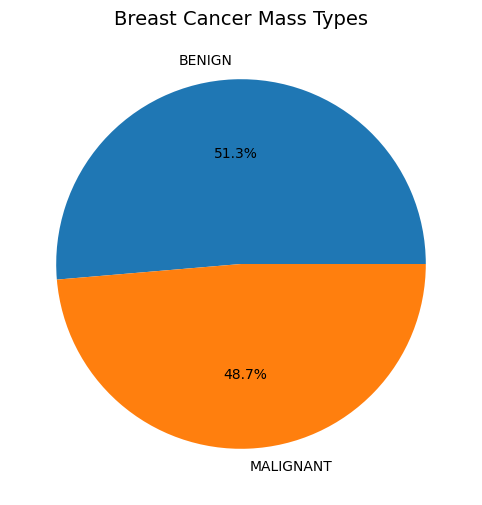

In [ ]:
# pathology distributions
value = mass_train['label'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.savefig('/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/OUR_STUFF/Figures/pathology_distributions_red.png')
plt.show()

In [ ]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(mass_train, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()
plt.savefig('/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/OUR_STUFF/Figures/density_pathology_red.png')
plt.show()

ValueError: Could not interpret value `breast_density` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

Full Mammograms:



KeyError: 'image_file_path'

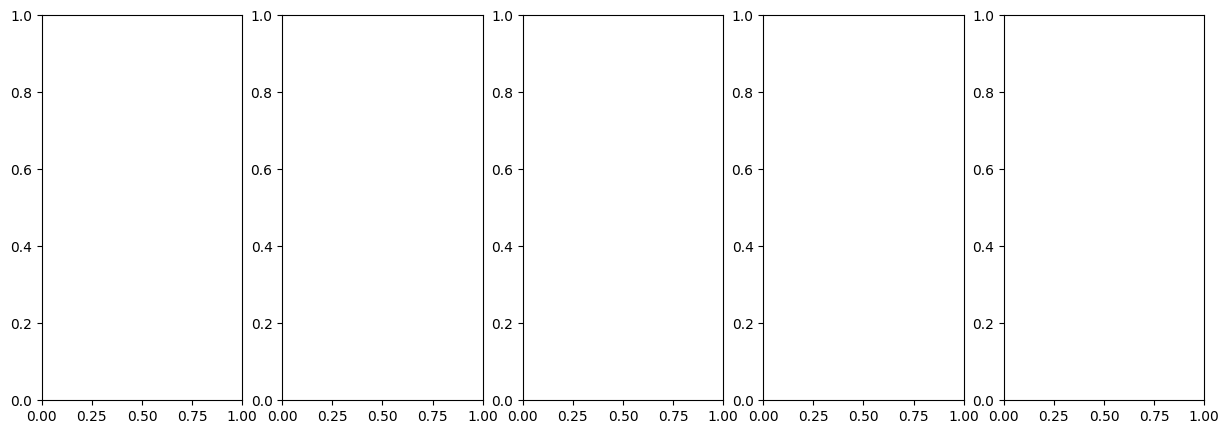

In [ ]:
# Display some images
import matplotlib.image as mpimg

# create function to display images
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

# Handle Categorical Data

## One Hot Encode

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

# Create a binary mapper
class_mapper = {
    'MALIGNANT': np.float32(1), 
    'BENIGN': np.float32(0), 
    'BENIGN_WITHOUT_CALLBACK': np.float32(0)} 

# Apply class mapper to pathology column
full_mass['labels'] = full_mass['label'].replace(class_mapper)

# One Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas"))
])

""" ohe_data = categorical_transformer.fit_transform(full_mass[[
    "image_view", 
    "left_or_right_breast", 
    "mass_shape",
    "mass_margins"
]])

full_mass_onehot = pd.merge(full_mass, ohe_data, left_index=True, right_index=True)

print(full_mass_onehot.shape)

# Check the number of classes
num_classes = len(full_mass_onehot['labels'].unique()) """

C:\Users\ciwan\AppData\Local\Temp\ipykernel_22084\3386162704.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_mass['labels'] = full_mass['label'].replace(class_mapper)


' ohe_data = categorical_transformer.fit_transform(full_mass[[\n    "image_view", \n    "left_or_right_breast", \n    "mass_shape",\n    "mass_margins"\n]])\n\nfull_mass_onehot = pd.merge(full_mass, ohe_data, left_index=True, right_index=True)\n\nprint(full_mass_onehot.shape)\n\n# Check the number of classes\nnum_classes = len(full_mass_onehot[\'labels\'].unique()) '

## Create Subsets

In [17]:
class_1 = ["image_view", "left_or_right_breast"]
class_2 = ["mass_shape", "mass_margins"]

counter = 0

def oh_col_list(original_cols, counter_init_val):
    counter = counter_init_val
    oh_cols = []
    for col in original_cols:
        vals = full_mass_onehot[col].unique()
        for val in vals:
            oh_cols.append(f'x{counter}_{val}')
        counter += 1
    return oh_cols, counter

class_1_cols, counter = oh_col_list(class_1, 0)
class_2_cols, _ = oh_col_list(class_2, counter)
class_3_cols, _ = oh_col_list(class_1 + class_2, 0)

img_col_name = 'processed_images'
class_2_cols = class_2_cols + ['breast_density', 'subtlety']
class_3_cols = class_3_cols + ['breast_density', 'subtlety']
# class_4_cols = class_3_cols + ["subtlety"]

NameError: name 'full_mass_onehot' is not defined

# Preprocessing of Images

In [ ]:
import tensorflow as tf
from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split, KFold
from keras.utils import to_categorical, set_random_seed
set_random_seed(42)
np.random.seed(42)

In [ ]:
# Testing for DICOM files
import pydicom as dicom
""" pd.options.display.max_rows = 4000
paths_array = full_mass['img_path'].apply(lambda x: os.path.abspath(x)).tolist()
print(paths_array[0])
img = dicom.dcmread(paths_array[0])
#print(img)
pixel_img = img.pixel_array
print(pixel_img)
resized_img_array = cv2.resize(pixel_img, (224,224))
resized_img_array = cv2.cvtColor(resized_img_array, cv2.COLOR_GRAY2RGB)
resized_img_array = resized_img_array.astype(float)
resized_img_array = np.round(((resized_img_array - np.min(resized_img_array)) / (np.max(resized_img_array) - np.min(resized_img_array))) * 255)
print(resized_img_array.shape) """


" pd.options.display.max_rows = 4000\npaths_array = full_mass['img_path'].apply(lambda x: os.path.abspath(x)).tolist()\nprint(paths_array[0])\nimg = dicom.dcmread(paths_array[0])\n#print(img)\npixel_img = img.pixel_array\nprint(pixel_img)\nresized_img_array = cv2.resize(pixel_img, (224,224))\nresized_img_array = cv2.cvtColor(resized_img_array, cv2.COLOR_GRAY2RGB)\nresized_img_array = resized_img_array.astype(float)\nresized_img_array = np.round(((resized_img_array - np.min(resized_img_array)) / (np.max(resized_img_array) - np.min(resized_img_array))) * 255)\nprint(resized_img_array.shape) "

In [ ]:
from cv2 import resize


def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    absolute_image_path = os.path.abspath(image_path)
    img = dicom.dcmread(absolute_image_path)
    pixel_img = img.pixel_array
    #print(pixel_img.shape)
    #print(pixel_img)
    resized_img_array = cv2.resize(pixel_img, target_size)
    resized_img_array = cv2.cvtColor(resized_img_array, cv2.COLOR_GRAY2RGB)
    resized_img_array = resized_img_array.astype(float)
    resized_img_array = np.round(((resized_img_array - np.min(resized_img_array)) / (np.max(resized_img_array) - np.min(resized_img_array))) * 255)
    #print(resized_img_array.shape)
    return resized_img_array

print(type(full_mass["img_path"]))
series = full_mass['img_path']

# Define the target size
# This used to be (224, 224, 3)
# Not sure why we need 3 dimensions,
# but had to remove it to work.
target_size = (224, 224)

image_column = series.apply(lambda x: image_processor(x, target_size))
print(image_column.shape)


<class 'pandas.core.series.Series'>
(1584,)


In [ ]:

PATH_TO_FILE = "/Code/KEX-Job/Breast-Cancer-Detection-Mammogram-Deep-Learning/code/saved_models/dataset-CBIS-DDSM_mammogramtype-all_model-MobileNet_lr-0.0001_b-2_e1-100_e2-50_roi-False__saved-model.h5"
def pre_trained_model(filepath):
    return keras.saving.load_model(filepath)

pre_trained = pre_trained_model(PATH_TO_FILE)

In [ ]:
print(image_column)
print(full_mass.columns)
print(full_mass["labels"])

0      [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...
1      [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...
2      [[[243.0, 243.0, 243.0], [243.0, 243.0, 243.0]...
3      [[[191.0, 191.0, 191.0], [192.0, 192.0, 192.0]...
4      [[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...
                             ...                        
354    [[[4.0, 4.0, 4.0], [3.0, 3.0, 3.0], [1.0, 1.0,...
355    [[[114.0, 114.0, 114.0], [80.0, 80.0, 80.0], [...
356    [[[236.0, 236.0, 236.0], [237.0, 237.0, 237.0]...
357    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
358    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: img_path, Length: 1584, dtype: object
Index(['img', 'img_path', 'label', 'labels'], dtype='object')
0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
354    0.0
355    1.0
356    1.0
357    1.0
358    1.0
Name: labels, Length: 1584, dtype: float32


In [ ]:
sess = tf.compat.v1.Session()
print("GPUs: ", tf.config.list_physical_devices('GPU'))
print(sess)
from tensorflow.python.client import device_lib
print(tf.config.list_physical_devices())
print(device_lib.list_local_devices())

GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16172623468976888861
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5744099328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5981020654227896753
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [ ]:
full_mass_onehot[img_col_name] = image_column

NameError: name 'full_mass_onehot' is not defined

In [ ]:
# Splitting without a validation set in the training set
'''
X_train, X_test, y_train, y_test = train_test_split(full_mass_onehot, full_mass_onehot['labels'].values, test_size = 0.2, random_state = 42)

X_train_0 = np.asarray(X_train[img_col_name].to_list())
X_test_0 = np.asarray(X_test[img_col_name].to_list())
y_train = y_train
y_test = y_test

print(X_train[[img_col_name, "breast_density"]].head(1))
print(class_1_cols)
print([img_col_name, "breast_density"])

X_train_1 = np.asarray(X_train[class_1_cols])
X_test_1 = np.asarray(X_test[class_1_cols])

X_train_2 = np.asarray(X_train[class_2_cols])
X_test_2 = np.asarray(X_test[class_2_cols])

X_train_3 = np.asarray(X_train[class_3_cols])
X_test_3 = np.asarray(X_test[class_3_cols])

X_train_4 = np.asarray(X_train[class_4_cols])
X_test_4 = np.asarray(X_test[class_4_cols])

print('X_train_0 shape : {}' .format(X_train_0.shape))
print('X_test_0 shape : {}' .format(X_test_0.shape))
print('X_train_1 shape : {}' .format(X_train_1.shape[1]))
print('X_test_1 shape : {}' .format(X_test_1.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
'''

'\nX_train, X_test, y_train, y_test = train_test_split(full_mass_onehot, full_mass_onehot[\'labels\'].values, test_size = 0.2, random_state = 42)\n\nX_train_0 = np.asarray(X_train[img_col_name].to_list())\nX_test_0 = np.asarray(X_test[img_col_name].to_list())\ny_train = y_train\ny_test = y_test\n\nprint(X_train[[img_col_name, "breast_density"]].head(1))\nprint(class_1_cols)\nprint([img_col_name, "breast_density"])\n\nX_train_1 = np.asarray(X_train[class_1_cols])\nX_test_1 = np.asarray(X_test[class_1_cols])\n\nX_train_2 = np.asarray(X_train[class_2_cols])\nX_test_2 = np.asarray(X_test[class_2_cols])\n\nX_train_3 = np.asarray(X_train[class_3_cols])\nX_test_3 = np.asarray(X_test[class_3_cols])\n\nX_train_4 = np.asarray(X_train[class_4_cols])\nX_test_4 = np.asarray(X_test[class_4_cols])\n\nprint(\'X_train_0 shape : {}\' .format(X_train_0.shape))\nprint(\'X_test_0 shape : {}\' .format(X_test_0.shape))\nprint(\'X_train_1 shape : {}\' .format(X_train_1.shape[1]))\nprint(\'X_test_1 shape : {}\

In [ ]:
# Image dataset from original DICOM images
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(image_column, full_mass["labels"].values, test_size = 0.2, random_state=42)

X_train_ready = np.asarray(X_train_img.to_list())
X_test_ready = np.asarray(X_test_img.to_list())


In [ ]:
print(type(X_train_img))
print(X_train_img.shape)
print("\nX_train_ready shape: ", X_train_ready.shape)
print("\nFirst img: ", X_train_img.head(1))
print(X_test_img.shape)
print(y_train_img.shape)
print(y_test_img.shape)

print("Type of y_test and y_train: ", type(y_test_img), type(y_train_img))
y_train_img[0]

<class 'pandas.core.series.Series'>
(1267,)

X_train_ready shape:  (1267, 224, 224, 3)

First img:  552    [[[246.0, 246.0, 246.0], [80.0, 80.0, 80.0], [...
Name: img_path, dtype: object
(317,)
(1267,)
(317,)
Type of y_test and y_train:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>


0.0

In [ ]:
# Splitting with a validation set in the training set
# by splitting the training set again with 20% for validation set
X_train_preval, X_test, y_train_preval, y_test = train_test_split(full_mass_onehot, full_mass_onehot['labels'].values, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_preval, y_train_preval, test_size=0.2, random_state=42)

X_train_0 = np.asarray(X_train[img_col_name].to_list())
X_val_0 = np.asarray(X_val[img_col_name].to_list())
X_test_0 = np.asarray(X_test[img_col_name].to_list())
y_train = y_train
y_test = y_test

print(X_train[[img_col_name, "breast_density"]].head(1))
print(class_1_cols)
print([img_col_name, "breast_density"])

X_train_1 = np.asarray(X_train[class_1_cols])
X_val_1 = np.asarray(X_val[class_1_cols])
X_test_1 = np.asarray(X_test[class_1_cols])

X_train_2 = np.asarray(X_train[class_2_cols])
X_val_2 = np.asarray(X_val[class_2_cols])
X_test_2 = np.asarray(X_test[class_2_cols])

X_train_3 = np.asarray(X_train[class_3_cols])
X_val_3 = np.asarray(X_val[class_3_cols])
X_test_3 = np.asarray(X_test[class_3_cols])

print('X_train_0 shape : {}' .format(X_train_0.shape))
print('X_test_0 shape : {}' .format(X_test_0.shape))
print('X_train_1 shape : {}' .format(X_train_1.shape[1]))
print('X_test_1 shape : {}' .format(X_test_1.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

NameError: name 'full_mass_onehot' is not defined

# CNN Architecture

In [ ]:
from keras.models import Model
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras import metrics
from keras.callbacks import LambdaCallback

In [ ]:
vgg19_train_input = keras.applications.vgg19.preprocess_input(X_train_0)
vgg19_val_input = keras.applications.vgg19.preprocess_input(X_val_0)
vgg19_test_input = keras.applications.vgg19.preprocess_input(X_test_0)
xception_train_input = keras.applications.xception.preprocess_input(X_train_0)
xception_val_input = keras.applications.xception.preprocess_input(X_val_0)
xception_test_input = keras.applications.xception.preprocess_input(X_test_0)

In [ ]:
# Preprocessing DICOM images
vgg19_train_dicom_input = keras.applications.vgg19.preprocess_input(X_train_ready)
vgg19_test_dicom_input = keras.applications.vgg19.preprocess_input(X_test_ready)
xception_train_dicom_input = keras.applications.xception.preprocess_input(X_train_ready)
xception_test_dicom_input = keras.applications.xception.preprocess_input(X_test_ready)

In [ ]:
def original_model(input_shape):
    input_img = layers.Input(shape=input_shape)
    a = layers.Conv2D(32, 3, padding='valid', activation='relu')(input_img)
    a = layers.MaxPooling2D()(a)
    a = layers.Conv2D(64, 3, padding='valid', activation='relu')(a)
    a = layers.MaxPooling2D()(a)
    a = layers.Flatten()(a)
    a = layers.Dense(64)(a)
    a = layers.Dense(1, activation='sigmoid')(a)
    return Model(inputs=input_img, outputs=a)

def vgg19_model():
    vgg19_model = VGG19(include_top=False, weights='imagenet')
    for layer in vgg19_model.layers:
        layer.trainable=False
    c = layers.GlobalMaxPooling2D()(vgg19_model.output)
    c = layers.Dense(2048, activation='relu')(c)
    c = layers.Dropout(0.005)(c)
    c = layers.Dense(1024, activation='relu')(c)
    c = layers.Dropout(0.005)(c)
    c = layers.Dense(1024, activation='relu')(c)
    c = layers.Dense(1, activation='sigmoid')(c)
    return Model(inputs=vgg19_model.input, outputs=c)

def xception_model():
    xception_model = Xception(include_top=False, weights='imagenet')
    for layer in xception_model.layers:
        layer.trainable=False
    c = layers.GlobalMaxPooling2D()(xception_model.output)
    c = layers.Dense(1024, activation='relu')(c)
    c = layers.Dropout(0.005)(c)
    c = layers.Dense(512, activation='relu')(c)
    c = layers.Dense(1, activation='sigmoid')(c)
    return Model(inputs=xception_model.input, outputs=c)

def cat_model(input_shape):
    input_cat = layers.Input(shape=input_shape)
    b = layers.Dense(32, activation="relu")(input_cat)
    b = layers.Dense(32, activation="relu")(b)
    b = layers.Dense(1, activation="sigmoid")(b)
    return Model(inputs=input_cat, outputs=b)

def combo_model(image_model, cat_input_shape):
    a = image_model
    b = cat_model(cat_input_shape)
    print("Image output pre-concat: ", (a.output))
    print("Categorical output pre-concat: ", b.output)
    c = layers.concatenate([a.output, b.output], name="concat_layer")
    #c = layers.BatchNormalization()(c)
    c = layers.Dense(units=12, kernel_regularizer="l1", kernel_constraint=keras.constraints.MaxNorm(max_value=1., axis=1), name="first_dense_layer")(c)
    c = layers.Reshape((3,4))(c)
    c = layers.Conv1D(2, 2, padding='valid', activation='relu')(c)
    c = layers.MaxPooling1D()(c)
    c = layers.Flatten()(c)
    c = layers.Dense(4)(c)
    c = layers.Dense(1, activation="sigmoid")(c)
    model = Model(inputs=[a.input, b.input], outputs=c)
    #print(model.summary())

    return model

def og_combo_model(image_model, cat_input_shape):
    a = image_model
    b = cat_model(cat_input_shape)
    print("Image output pre-concat: ", (a.output))
    print("Categorical output pre-concat: ", b.output)
    c = layers.concatenate([a.output, b.output], name="concat_layer")
    c = layers.Dense(units=2, activation="relu")(c)
    c = layers.Dense(1, activation="sigmoid")(c)
    model = Model(inputs=[a.input, b.input], outputs=c)
    #print(model.summary())

    return model
    

# Parameters

In [ ]:
# Compile
!pip install tensorflow-addons==0.16.1
#import tensorflow_addons as tfa
model_optimizer_OLD = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model_optimizer = "rmsprop"
model_metrics = [
    metrics.BinaryAccuracy(),
    metrics.Recall(),
    metrics.Precision(),
    #tfa.metrics.F1Score()
]

# Fit
batch_size = 32
epochs=12

In [ ]:
from keras.models import Model
from keras import metrics
from keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay

lr_scheduler1 = ExponentialDecay(initial_learning_rate=0.99, decay_steps=10000000000, decay_rate=0.95)
lr_scheduler2 = PiecewiseConstantDecay([100000000000000], [1.0, 0.4])
sgd_optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.4, nesterov=False)

def train_combo_model(image_input, cat_input, image_model, labels, img_val, cat_val, y_val):
    model = combo_model(image_model, cat_input.shape[1])
    model.compile(
        loss='binary_crossentropy', 
        optimizer=model_optimizer,
        metrics=model_metrics
    )
    print_outputs = LambdaCallback(on_epoch_end=lambda batch, logs: print("Layer output: ", keras.backend.eval(model.get_layer("concat_layer"))))
    print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print("Layer weights: ", np.linalg.norm(model.get_layer("first_dense_layer").get_weights()[0]),np.linalg.norm(model.get_layer("first_dense_layer").get_weights()[1])))
    history = model.fit([image_input, cat_input], labels, batch_size=batch_size, epochs=epochs, validation_data=([img_val, cat_val], y_val),verbose=2, callbacks = [print_outputs, print_weights])
    return model, history

def train_og_combo_model(image_input, cat_input, image_model, labels, img_val, cat_val, y_val):
    model = combo_model(image_model, cat_input.shape[1])
    model.compile(
        loss='binary_crossentropy', 
        optimizer=model_optimizer,
        metrics=model_metrics
    )
    print_outputs = LambdaCallback(on_epoch_end=lambda batch, logs: print("Layer output: ", keras.backend.eval(model.get_layer("concat_layer"))))
    print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print("Layer weights: ", np.linalg.norm(model.get_layer("first_dense_layer").get_weights()[0]),np.linalg.norm(model.get_layer("first_dense_layer").get_weights()[1])))
    history = model.fit([image_input, cat_input], labels, batch_size=batch_size, epochs=epochs, validation_data=([img_val, cat_val], y_val),verbose=2, callbacks = [print_outputs, print_weights])
    return model, history

# Training and Evaluation

# Categorical Data Only

In [ ]:
def train_cat_model(x, y, x_val, y_val):
    model = cat_model(x.shape[1])
    model.compile(
        loss='binary_crossentropy', 
        # optimizer=keras.optimizers.Adam(learning_rate=0.001),
        optimizer=model_optimizer,
        metrics=model_metrics
    )
    history = model.fit([x], y, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=2)
    return model, history
    
cat_model_1, cat_1_fit_history = train_cat_model(X_train_1, y_train, X_val_1, y_val)
cat_model_2, cat_2_fit_history = train_cat_model(X_train_2, y_train, X_val_2, y_val)
cat_model_3, cat_3_fit_history = train_cat_model(X_train_3, y_train, X_val_3, y_val)
    
print("")
cat_1_eval_history = cat_model_1.evaluate(X_test_1, y_test)
cat_2_eval_history = cat_model_2.evaluate(X_test_2, y_test)
cat_3_eval_history = cat_model_3.evaluate(X_test_3, y_test)

# Original Combo Model

In [ ]:
og_combo_model_1, og_combo_1_fit_history = train_og_combo_model(X_train_0, X_train_1, original_model(target_size), y_train, X_val_0, X_val_1, y_val)
print("")
og_combo_model_2, og_combo_2_fit_history = train_og_combo_model(X_train_0, X_train_2, original_model(target_size), y_train, X_val_0, X_val_2, y_val)
print("")
og_combo_model_3, og_combo_3_fit_history = train_og_combo_model(X_train_0, X_train_3, original_model(target_size), y_train, X_val_0, X_val_3, y_val)

In [ ]:
og_combo_1_eval_history = og_combo_model_1.evaluate([X_test_0, X_test_1], y_test)
og_combo_2_eval_history = og_combo_model_2.evaluate([X_test_0, X_test_2], y_test)
og_combo_3_eval_history = og_combo_model_3.evaluate([X_test_0, X_test_3], y_test)

# Original Kex Model

In [ ]:
og_model_0 = original_model(target_size)
og_model_0.compile(optimizer=model_optimizer, 
               loss='binary_crossentropy',
               metrics=[
                    metrics.BinaryAccuracy(),
                    metrics.Recall(),
                    metrics.Precision(),
                    metrics.F1Score()]
              )
og_0_fit_history = og_model_0.fit(X_train_0, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_0, y_val) ,verbose=2)
og_0_eval_history = og_model_0.evaluate(X_test_0, y_test)

In [ ]:
og_model_1, og_1_fit_history = train_combo_model(X_train_0, X_train_1, original_model(target_size), y_train, X_val_0, X_val_1, y_val)
print("")
og_model_2, og_2_fit_history = train_combo_model(X_train_0, X_train_2, original_model(target_size), y_train, X_val_0, X_val_2, y_val)
print("")
og_model_3, og_3_fit_history = train_combo_model(X_train_0, X_train_3, original_model(target_size), y_train, X_val_0, X_val_3, y_val)

In [ ]:
og_1_eval_history = og_model_1.evaluate([X_test_0, X_test_1], y_test)
og_2_eval_history = og_model_2.evaluate([X_test_0, X_test_2], y_test)
og_3_eval_history = og_model_3.evaluate([X_test_0, X_test_3], y_test)

# XCeption Models

In [ ]:
xception_model_0 = xception_model()

xception_model_0.compile(optimizer="sgd", 
               loss='binary_crossentropy',
               metrics=model_metrics
                        )
y_train_img_2d = np.expand_dims(y_train_img, -1)
y_test_img_2d = np.expand_dims(y_test_img, -1)
xception_0_fit_history = xception_model_0.fit(xception_train_dicom_input, y_train_img_2d, batch_size=batch_size, epochs=12 ,verbose=2)

Epoch 1/12
40/40 - 5s - loss: 0.8433 - binary_accuracy: 0.5221 - recall: 0.4628 - precision: 0.4872 - 5s/epoch - 118ms/step
Epoch 2/12
40/40 - 2s - loss: 0.6921 - binary_accuracy: 0.5564 - recall: 0.4344 - precision: 0.5258 - 2s/epoch - 54ms/step
Epoch 3/12
40/40 - 2s - loss: 0.6577 - binary_accuracy: 0.6062 - recall: 0.4668 - precision: 0.5957 - 2s/epoch - 54ms/step
Epoch 4/12
40/40 - 2s - loss: 0.6542 - binary_accuracy: 0.5991 - recall: 0.4872 - precision: 0.5801 - 2s/epoch - 54ms/step
Epoch 5/12
40/40 - 2s - loss: 0.6343 - binary_accuracy: 0.6275 - recall: 0.5349 - precision: 0.6121 - 2s/epoch - 54ms/step
Epoch 6/12
40/40 - 2s - loss: 0.6218 - binary_accuracy: 0.6614 - recall: 0.5826 - precision: 0.6502 - 2s/epoch - 54ms/step
Epoch 7/12
40/40 - 2s - loss: 0.6210 - binary_accuracy: 0.6480 - recall: 0.5571 - precision: 0.6374 - 2s/epoch - 54ms/step
Epoch 8/12
40/40 - 2s - loss: 0.6051 - binary_accuracy: 0.6740 - recall: 0.6082 - precision: 0.6611 - 2s/epoch - 54ms/step
Epoch 9/12
40/4

In [ ]:
xception_0_eval_history = xception_model_0.evaluate(xception_test_dicom_input, y_test_img, batch_size=1)

317/317 [==============================] - 3s 7ms/step - loss: 0.6614 - binary_accuracy: 0.5994 - recall: 0.4474 - precision: 0.6126


In [ ]:
xception_model_1, xception_1_fit_history = train_combo_model(xception_train_input, X_train_1, xception_model(), y_train, xception_val_input, X_val_1, y_val)
print("")
xception_model_2, xception_2_fit_history = train_combo_model(xception_train_input, X_train_2, xception_model(), y_train, xception_val_input, X_val_2, y_val)
print("")
xception_model_3, xception_3_fit_history = train_combo_model(xception_train_input, X_train_3, xception_model(), y_train, xception_val_input, X_val_3, y_val)

In [ ]:
xception_1_eval_history = xception_model_1.evaluate([xception_test_input, X_test_1], y_test)
xception_2_eval_history = xception_model_2.evaluate([xception_test_input, X_test_2], y_test)
xception_3_eval_history = xception_model_3.evaluate([xception_test_input, X_test_3], y_test)

# VGG19 Models

In [ ]:
vgg19_model_0 = vgg19_model()

vgg19_model_0.compile(optimizer=model_optimizer, 
               loss='binary_crossentropy',
               metrics=[
                    metrics.BinaryAccuracy(),
                    metrics.Recall(),
                    metrics.Precision(),
                    metrics.F1Score()]
              )

vgg19_0_fit_history = vgg19_model_0.fit(vgg19_train_input, y_train, batch_size=batch_size, epochs=epochs, validation_data=(vgg19_val_input, y_val), verbose=2)
vgg19_0_eval_history = vgg19_model_0.evaluate(vgg19_test_input, y_test)

In [ ]:
vgg19_model_1, vgg19_1_fit_history = train_combo_model(vgg19_train_input, X_train_1, vgg19_model(), y_train, vgg19_val_input, X_val_1, y_val)
print("")
vgg19_model_2, vgg19_2_fit_history = train_combo_model(vgg19_train_input, X_train_2, vgg19_model(), y_train, vgg19_val_input, X_val_2, y_val)
print("")
vgg19_model_3, vgg19_3_fit_history = train_combo_model(vgg19_train_input, X_train_3, vgg19_model(), y_train, vgg19_val_input, X_val_3, y_val)

In [ ]:
vgg19_1_eval_history = vgg19_model_1.evaluate([vgg19_test_input, X_test_1], y_test)
vgg19_1_eval_history = vgg19_model_2.evaluate([vgg19_test_input, X_test_2], y_test)
vgg19_1_eval_history = vgg19_model_3.evaluate([vgg19_test_input, X_test_3], y_test)

# Graphs

In [ ]:
def broken_loss_graph(history, top_upper_lim, top_lower_lim, bottom_upper_lim, bottom_lower_lim):
    pts1 = history['loss']
    pts2 = history['val_loss']
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(hspace=0.05)  # adjust space between axes

    # plot the same data on both axes
    ax1.plot(pts1, label='Training loss')
    ax2.plot(pts1, label='Training loss')
    ax1.plot(pts2, label='Validation loss')
    ax2.plot(pts2, label='Validation loss')

    # zoom-in / limit the view to different portions of the data
    ax1.set_ylim(top_lower_lim, top_upper_lim)  # outliers only
    ax2.set_ylim(bottom_lower_lim, bottom_upper_lim)  # most of the data

    # hide the spines between ax and ax2
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(top = False) 
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # Now, let's turn towards the cut-out slanted lines.
    # We create line objects in axes coordinates, in which (0,0), (0,1),
    # (1,0), and (1,1) are the four corners of the axes.
    # The slanted lines themselves are markers at those locations, such that the
    # lines keep their angle and position, independent of the axes size or scale
    # Finally, we need to disable clipping.

    d = .7  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    
    ax1.legend(loc="upper right")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
broken_loss_graph(vgg19_0_fit_history.history, 70., 50., 2., 0)

In [ ]:
import matplotlib.pyplot as plt

def accuracy_graph(history, title):
    # Visualize model history
    plt.plot(history['binary_accuracy'], label='Training accuracy')
    plt.plot(history['val_binary_accuracy'], label='Validation accuracy')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc="upper left")
    plt.show()
    
def loss_graph(history, title):
    plt.plot(history['loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.title(title)
    plt.ylabel('Loss value')
    plt.xlabel('Epoch')
    plt.legend(loc="upper right")
    plt.show()
    
def recall_graph(history, title):
    keys = list(history.keys())
    train_recall = keys[2]
    train_precision = keys[3]
    val_recall = keys[7]
    val_precision = keys[8]
    print(f'{train_recall}, {train_precision}, {val_recall}, {val_precision}')
    # Visualize model history
    plt.plot(history[train_recall], label='Training recall')
    plt.plot(history[train_precision], label='Validation recall')
    plt.title(title)
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
# Loss graphs
loss_graph(cat_1_fit_history.history, "Categorical Data Only Class 1 - Loss")
loss_graph(cat_2_fit_history.history, "Categorical Data Only Class 2 - Loss")
loss_graph(cat_3_fit_history.history, "Categorical Data Only Class 3 - Loss")

loss_graph(og_combo_1_fit_history.history, "Alzheimer's Combo Class 1 - Loss")
loss_graph(og_combo_2_fit_history.history, "Alzheimer's Combo Class 2 - Loss")
loss_graph(og_combo_3_fit_history.history, "Alzheimer's Combo Class 3 - Loss")

loss_graph(og_0_fit_history.history, "Alzheimer's Image Only - Loss")
loss_graph(og_1_fit_history.history, "Alzheimer's Enhanced Class 1 - Loss")
loss_graph(og_2_fit_history.history, "Alzheimer's Enhanced Class 2 - Loss")
loss_graph(og_3_fit_history.history, "Alzheimer's Enhanced Class 3 - Loss")

loss_graph(vgg19_0_fit_history.history, "VGG19 Image Only - Loss")
loss_graph(vgg19_1_fit_history.history, "VGG19 Class 1 - Loss")
loss_graph(vgg19_2_fit_history.history, "VGG19 Class 2 - Loss")
loss_graph(vgg19_3_fit_history.history, "VGG19 Class 3 - Loss")

loss_graph(xception_0_fit_history.history, "XCeption Image Only - Loss")
loss_graph(xception_1_fit_history.history, "XCeption Class 1 - Loss")
loss_graph(xception_2_fit_history.history, "XCeption Class 2 - Loss")
loss_graph(xception_3_fit_history.history, "XCeption Class 3 - Loss")

In [ ]:
# Loss graphs without titles
print("\nCategorical Data Only Class 1 - Loss")
loss_graph(cat_1_fit_history.history, "")
print("\nCategorical Data Only Class 2 - Loss")
loss_graph(cat_2_fit_history.history, "")
print("\nCategorical Data Only Class 3 - Loss")
loss_graph(cat_3_fit_history.history, "")

print("\Alzheimer's Combo Class 1 - Loss")
loss_graph(og_combo_1_fit_history.history, "")
print("\Alzheimer's Combo Class 2 - Loss")
loss_graph(og_combo_2_fit_history.history, "")
print("\Alzheimer's Combo Class 3 - Loss")
loss_graph(og_combo_3_fit_history.history, "")

print("\nAlzheimer's Image Only - Loss")
loss_graph(og_0_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 1 - Loss")
loss_graph(og_1_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 2 - Loss")
loss_graph(og_2_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 3 - Loss")
loss_graph(og_3_fit_history.history, "")

print("\nVGG19 Image Only - Loss")
loss_graph(vgg19_0_fit_history.history, "")
print("\nVGG19 Class 1 - Loss")
loss_graph(vgg19_1_fit_history.history, "")
print("\nVGG19 Class 2 - Loss")
loss_graph(vgg19_2_fit_history.history, "")
print("\nVGG19 Class 3 - Loss")
loss_graph(vgg19_3_fit_history.history, "")

print("\nXCeption Image Only - Loss")
loss_graph(xception_0_fit_history.history, "")
print("\nXCeption Class 1 - Loss")
loss_graph(xception_1_fit_history.history, "")
print("\nXCeption Class 2 - Loss")
loss_graph(xception_2_fit_history.history, "")
print("\nXCeption Class 3 - Loss")
loss_graph(xception_3_fit_history.history, "")

In [ ]:
# Accuracy graphs
accuracy_graph(cat_1_fit_history.history, "Categorical Data Only Class 1 - Accuracy")
accuracy_graph(cat_2_fit_history.history, "Categorical Data Only Class 2 - Accuracy")
accuracy_graph(cat_3_fit_history.history, "Categorical Data Only Class 3 - Accuracy")

accuracy_graph(og_combo_1_fit_history.history, "Alzheimer's Combo Class 1 - Accuracy")
accuracy_graph(og_combo_2_fit_history.history, "Alzheimer's Combo Class 2 - Accuracy")
accuracy_graph(og_combo_3_fit_history.history, "Alzheimer's Combo Class 3 - Accuracy")

accuracy_graph(og_0_fit_history.history, "Alzheimer's Image Only - Accuracy")
accuracy_graph(og_1_fit_history.history, "Alzheimer's Enhanced Class 1 - Accuracy")
accuracy_graph(og_2_fit_history.history, "Alzheimer's Enhanced Class 2 - Accuracy")
accuracy_graph(og_3_fit_history.history, "Alzheimer's Enhanced Class 3 - Accuracy")

accuracy_graph(vgg19_0_fit_history.history, "VGG19 Image Only - Accuracy")
accuracy_graph(vgg19_1_fit_history.history, "VGG19 Class 1 - Accuracy")
accuracy_graph(vgg19_2_fit_history.history, "VGG19 Class 2 - Accuracy")
accuracy_graph(vgg19_3_fit_history.history, "VGG19 Class 3 - Accuracy")

accuracy_graph(xception_0_fit_history.history, "XCeption Image Only - Accuracy")
accuracy_graph(xception_1_fit_history.history, "XCeption Class 1 - Accuracy")
accuracy_graph(xception_2_fit_history.history, "XCeption Class 2 - Accuracy")
accuracy_graph(xception_3_fit_history.history, "XCeption Class 3 - Accuracy")

In [ ]:
# Accuracy graphs without title
print("\nCategorical Data Only Class 1 - Accuracy")
accuracy_graph(cat_1_fit_history.history, "")
print("\nCategorical Data Only Class 2 - Accuracy")
accuracy_graph(cat_2_fit_history.history, "")
print("\nCategorical Data Only Class 3 - Accuracy")
accuracy_graph(cat_3_fit_history.history, "")

print("\nAlzheimer's Combo Class 1 - Accuracy")
accuracy_graph(og_combo_1_fit_history.history, "")
print("\nAlzheimer's Combo Class 2 - Accuracy")
accuracy_graph(og_combo_2_fit_history.history, "")
print("\nAlzheimer's Combo Class 3 - Accuracy")
accuracy_graph(og_combo_3_fit_history.history, "")

print("\nAlzheimer's Image Only - Accuracy")
accuracy_graph(og_0_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 1 - Accuracy")
accuracy_graph(og_1_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 2 - Accuracy")
accuracy_graph(og_2_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 3 - Accuracy")
accuracy_graph(og_3_fit_history.history, "")

print("\nVGG19 Image Only - Accuracy")
accuracy_graph(vgg19_0_fit_history.history, "")
print("\nVGG19 Class 1 - Accuracy")
accuracy_graph(vgg19_1_fit_history.history, "")
print("\nVGG19 Class 2 - Accuracy")
accuracy_graph(vgg19_2_fit_history.history, "")
print("\nVGG19 Class 3 - Accuracy")
accuracy_graph(vgg19_3_fit_history.history, "")

print("\nXCeption Image Only - Accuracy")
accuracy_graph(xception_0_fit_history.history, "")
print("\nXCeption Class 1 - Accuracy")
accuracy_graph(xception_1_fit_history.history, "")
print("\nXCeption Class 2 - Accuracy")
accuracy_graph(xception_2_fit_history.history, "")
print("\nXCeption Class 3 - Accuracy")
accuracy_graph(xception_3_fit_history.history, "")

In [ ]:
# Recall and precision graphs

print("\nCategorical Data Only Class 1 - Recall")
recall_graph(cat_1_fit_history.history, "")
print("\nCategorical Data Only Class 2 - Recall")
recall_graph(cat_2_fit_history.history, "")
print("\nCategorical Data Only Class 3 - Recall")
recall_graph(cat_3_fit_history.history, "")

print("\nAlzheimer's Combo Class 1 - Recall")
recall_graph(og_combo_1_fit_history.history, "")
print("\nAlzheimer's Combo Class 2 - Recall")
recall_graph(og_combo_2_fit_history.history, "")
print("\nAlzheimer's Combo Class 3 - Recall")
recall_graph(og_combo_3_fit_history.history, "")

print("\nAlzheimer's Image Only - Recall")
recall_graph(og_0_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 1 - Recall")
recall_graph(og_1_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 2 - Recall")
recall_graph(og_2_fit_history.history, "")
print("\nAlzheimer's Enhanced Class 3 - Recall")
recall_graph(og_3_fit_history.history, "")

print("\nVGG19 Image Only - Recall")
recall_graph(vgg19_0_fit_history.history, "")
print("\nVGG19 Class 1 - Recall")
recall_graph(vgg19_1_fit_history.history, "")
print("\nVGG19 Class 2 - Recall")
recall_graph(vgg19_2_fit_history.history, "")
print("\nVGG19 Class 3 - Recall")
recall_graph(vgg19_3_fit_history.history, "")

print("\nXCeption Image Only - Recall")
recall_graph(xception_0_fit_history.history, "")
print("\nXCeption Class 1 - Recall")
recall_graph(xception_1_fit_history.history, "")
print("\nXCeption Class 2 - Recall")
recall_graph(xception_2_fit_history.history, "")
print("\nXCeption Class 3 - Recall")
recall_graph(xception_3_fit_history.history, "")